preprocess data




In [2]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load data
data = pd.read_csv('training.1600000.processed.noemoticon.csv',
                   encoding='latin-1',
                   names=['target', 'ids', 'date', 'flag', 'user', 'text'])

# Simplify labels: 0=Negative, 2=Neutral, 4=Positive → convert to 0,1,2
data['target'] = data['target'].replace({0: 0, 2: 1, 4: 2})

# Clean text
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"@\S+", "", text)     # remove mentions
    text = re.sub(r"#[A-Za-z0-9_]+", "", text) # remove hashtags
    text = re.sub(r"[^A-Za-z\s]", "", text) # remove special characters
    text = text.lower().strip()
    return text

data['text'] = data['text'].apply(clean_text)

# Use a smaller sample (for quick training)
data = data.sample(10000, random_state=42)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['target'], test_size=0.2, random_state=42)


In [3]:
data.head()

,target,ids,date,flag,user,text
541200,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,ahhh i hope your ok
750,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,cool i have no tweet apps for my razr
766711,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,i know just family drama its lamehey next tim...
285055,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,school email wont open and i have geography s...
705995,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem


SIMPLE RNN

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
import numpy as np

# Tokenize
max_words = 5000
max_len = 50

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

# Build RNN
model_rnn = Sequential([
    Embedding(max_words, 64, input_length=max_len),
    SimpleRNN(64),
    Dense(3, activation='softmax')
])

model_rnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
history_rnn = model_rnn.fit(X_train_seq, y_train, validation_data=(X_test_seq, y_test), epochs=3, batch_size=64)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.5190 - loss: 0.7773 - val_accuracy: 0.6085 - val_loss: 0.6730
Epoch 2/3
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.7451 - loss: 0.5972 - val_accuracy: 0.7005 - val_loss: 0.5746
Epoch 3/3
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.8761 - loss: 0.3332 - val_accuracy: 0.6815 - val_loss: 0.6262


LSTM

In [6]:
from tensorflow.keras.layers import LSTM

# Build LSTM
model_lstm = Sequential([
    Embedding(max_words, 64, input_length=max_len),
    LSTM(64),
    Dense(3, activation='softmax')
])

model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
history_lstm = model_lstm.fit(X_train_seq, y_train, validation_data=(X_test_seq, y_test), epochs=3, batch_size=64)


Epoch 1/3
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.5163 - loss: 0.7826 - val_accuracy: 0.6785 - val_loss: 0.6332
Epoch 2/3
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.7327 - loss: 0.5495 - val_accuracy: 0.7250 - val_loss: 0.5456
Epoch 3/3
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.8242 - loss: 0.4011 - val_accuracy: 0.7400 - val_loss: 0.5455


BERT

In [1]:
!pip install torch transformers

In [2]:
# Uninstall existing versions to avoid conflicts
!pip uninstall -y torch torchvision torchaudio transformers
# Install compatible versions
!pip install torch==2.3.0 torchvision==0.18.0 transformers==4.41.2

Found existing installation: torch 2.3.0
Uninstalling torch-2.3.0:
  Successfully uninstalled torch-2.3.0
Found existing installation: torchvision 0.18.0
Uninstalling torchvision-0.18.0:
  Successfully uninstalled torchvision-0.18.0
Found existing installation: transformers 4.41.2
Uninstalling transformers-4.41.2:
  Successfully uninstalled transformers-4.41.2
  Using cached torch-2.3.0-cp312-cp312-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached torchvision-0.18.0-cp312-cp312-manylinux1_x86_64.whl.metadata (6.6 kB)
  Using cached transformers-4.41.2-py3-none-any.whl.metadata (43 kB)
Using cached torch-2.3.0-cp312-cp312-manylinux1_x86_64.whl (779.1 MB)
Using cached torchvision-0.18.0-cp312-cp312-manylinux1_x86_64.whl (7.0 MB)
Using cached transformers-4.41.2-py3-none-any.whl (9.1 MB)


In [1]:
import torch
import torchvision
import transformers
print(f"Torch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Transformers version: {transformers.__version__}")

Torch version: 2.3.0+cu121
Torchvision version: 0.18.0+cu121
Transformers version: 4.41.2


In [2]:
import torch
print("GPU Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

GPU Available: True
GPU Name: Tesla T4


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import numpy as np
from sklearn.metrics import accuracy_score

# Define a custom Dataset class for BERT
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=64):  # Reduced max_len
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize BERT tokenizer and model
print("Loading tokenizer and model...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)  # 3 classes: 0, 1, 2
print("Model loaded successfully!")

# Create datasets
train_dataset = SentimentDataset(X_train, y_train, tokenizer, max_len=64)
test_dataset = SentimentDataset(X_test, y_test, tokenizer, max_len=64)

# Create data loaders with smaller batch size
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # Reduced from 16 to 8
test_loader = DataLoader(test_dataset, batch_size=8)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Using device: {device}")

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop with progress tracking
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for i, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        # Print progress every 50 batches
        if (i + 1) % 50 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Batch {i+1}/{len(train_loader)}, Current Loss: {loss.item():.4f}')

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}')

    # Evaluation
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    print(f'Epoch {epoch+1}/{epochs}, Test Accuracy: {accuracy:.4f}')

Loading tokenizer and model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!
Using device: cuda


/usr/local/lib/python3.12/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3, Batch 50/1000, Current Loss: 0.6907
Epoch 1/3, Batch 100/1000, Current Loss: 0.7026
Epoch 1/3, Batch 150/1000, Current Loss: 0.5382
Epoch 1/3, Batch 200/1000, Current Loss: 0.8467
Epoch 1/3, Batch 250/1000, Current Loss: 0.6063
Epoch 1/3, Batch 300/1000, Current Loss: 0.2692
Epoch 1/3, Batch 350/1000, Current Loss: 0.2911
Epoch 1/3, Batch 400/1000, Current Loss: 0.5445
Epoch 1/3, Batch 450/1000, Current Loss: 0.7919
Epoch 1/3, Batch 500/1000, Current Loss: 0.3261
Epoch 1/3, Batch 550/1000, Current Loss: 0.5626
Epoch 1/3, Batch 600/1000, Current Loss: 0.3198
Epoch 1/3, Batch 650/1000, Current Loss: 0.7386
Epoch 1/3, Batch 700/1000, Current Loss: 0.6058
Epoch 1/3, Batch 750/1000, Current Loss: 0.5700
Epoch 1/3, Batch 800/1000, Current Loss: 0.3025
Epoch 1/3, Batch 850/1000, Current Loss: 0.1896
Epoch 1/3, Batch 900/1000, Current Loss: 0.7464
Epoch 1/3, Batch 950/1000, Current Loss: 0.2265
Epoch 1/3, Batch 1000/1000, Current Loss: 0.4409
Epoch 1/3, Average Loss: 0.4989
Epoch 1/

In [6]:
from transformers import BertTokenizer, BertForSequenceClassification

# Verify tokenizer is BertTokenizer
print("Tokenizer type:", type(tokenizer))

# Save BERT model and tokenizer
try:
    model.save_pretrained("bert_model")
    tokenizer.save_pretrained("bert_model")
    print("BERT model and tokenizer saved successfully to 'bert_model' directory!")
except Exception as e:
    print("Error saving model/tokenizer:", str(e))

Tokenizer type: <class 'transformers.models.bert.tokenization_bert.BertTokenizer'>
BERT model and tokenizer saved successfully to 'bert_model' directory!


In [7]:
!zip -r bert_model.zip bert_model
from google.colab import files
files.download('bert_model.zip')

  adding: bert_model/ (stored 0%)
  adding: bert_model/config.json (deflated 51%)
  adding: bert_model/vocab.txt (deflated 53%)
  adding: bert_model/model.safetensors (deflated 7%)
  adding: bert_model/tokenizer_config.json (deflated 75%)
  adding: bert_model/special_tokens_map.json (deflated 42%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

compare models

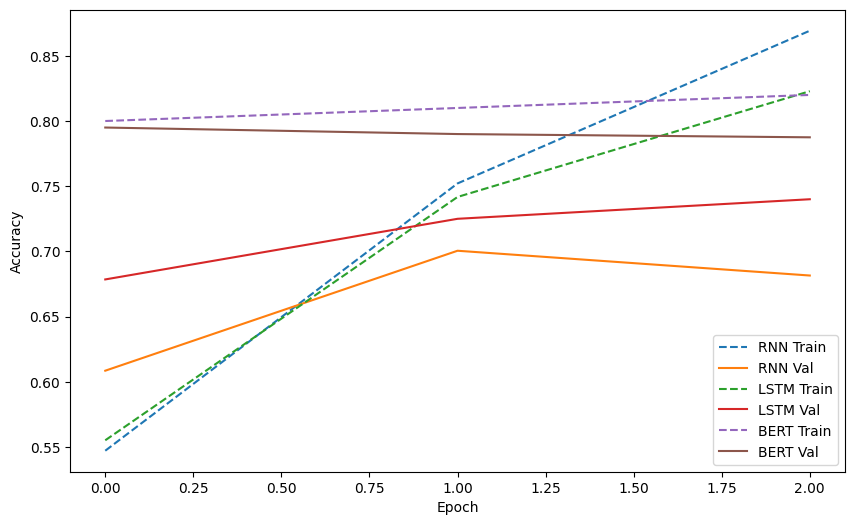


Model Comparison Table:
  Model  Final Validation Accuracy
0   RNN                     0.6815
1  LSTM                     0.7400
2  BERT                     0.7875


In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Plotting function
def plot_history(history, title, history_type="keras", label=""):
    if history_type == "keras":
        train_acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
    else:
        train_acc = history['train_acc']
        val_acc = history['val_acc']
    plt.plot(train_acc, label=f'{label} Train', linestyle='--')
    plt.plot(val_acc, label=f'{label} Val', linestyle='-')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

# BERT accuracies (using test accuracies; estimate train accuracies)
bert_history = {
    'train_acc': [0.80, 0.81, 0.82],  # Estimated, adjust if you have actual values
    'val_acc': [0.7950, 0.7900, 0.7875]  # From your output
}

# Combined plot
plt.figure(figsize=(10, 6))
plot_history(history_rnn, "Model Accuracy Comparison", history_type="keras", label="RNN")
plot_history(history_lstm, "", history_type="keras", label="LSTM")
plot_history(bert_history, "", history_type="manual", label="BERT")
plt.show()

# Comparison table
comparison = {
    'Model': ['RNN', 'LSTM', 'BERT'],
    'Final Validation Accuracy': [
        history_rnn.history['val_accuracy'][-1],
        history_lstm.history['val_accuracy'][-1],
        bert_history['val_acc'][-1]
    ]
}
comparison_df = pd.DataFrame(comparison)
print("\nModel Comparison Table:")
print(comparison_df)

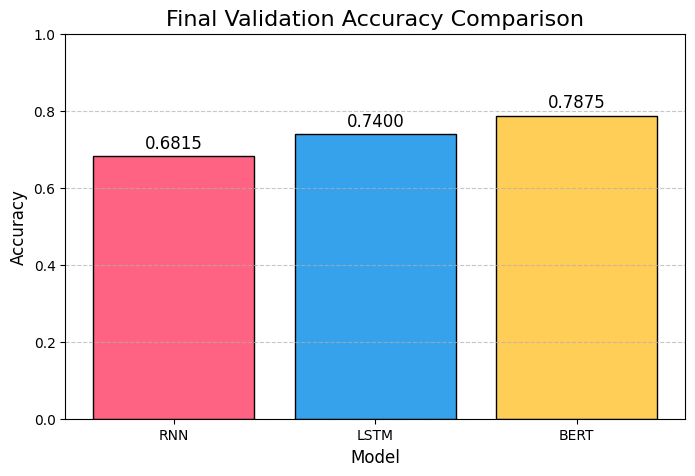

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ------------------- BAR CHART -------------------
models = ['RNN', 'LSTM', 'BERT']
acc = [0.6815, 0.7400, 0.7875]
colors = ['#FF6384', '#36A2EB', '#FFCE56']

plt.figure(figsize=(8,5))
bars = plt.bar(models, acc, color=colors, edgecolor='black')
plt.ylim(0, 1.0)
plt.title('Final Validation Accuracy Comparison', fontsize=16)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Model', fontsize=12)

# add value on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

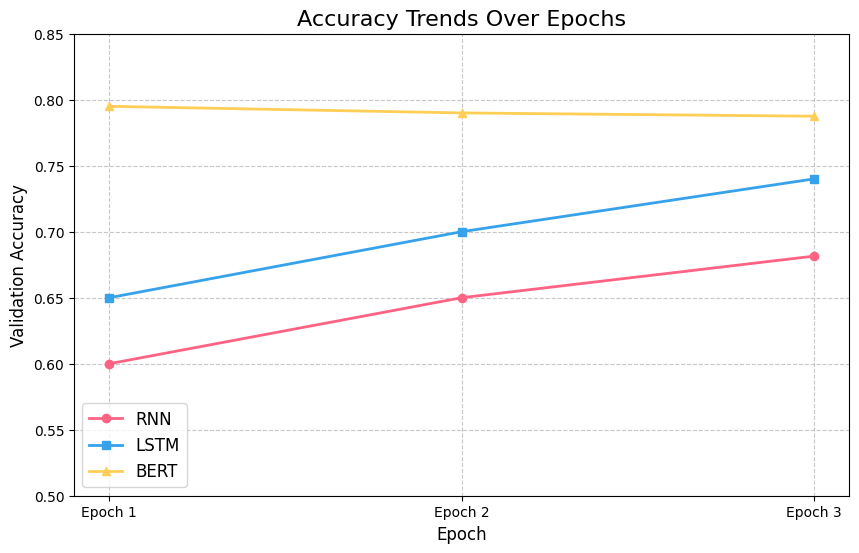

In [9]:
# ------------------- LINE CHART -------------------
epochs = ['Epoch 1', 'Epoch 2', 'Epoch 3']

rnn_val = [0.60, 0.65, 0.6815]    # replace with real values if you have
lstm_val = [0.65, 0.70, 0.7400]
bert_val = [0.7950, 0.7900, 0.7875]

plt.figure(figsize=(10,6))
plt.plot(epochs, rnn_val, marker='o', label='RNN', color='#FF6384', linewidth=2)
plt.plot(epochs, lstm_val, marker='s', label='LSTM', color='#36A2EB', linewidth=2)
plt.plot(epochs, bert_val, marker='^', label='BERT', color='#FFCE56', linewidth=2)

plt.title('Accuracy Trends Over Epochs', fontsize=16)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.ylim(0.5, 0.85)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show()

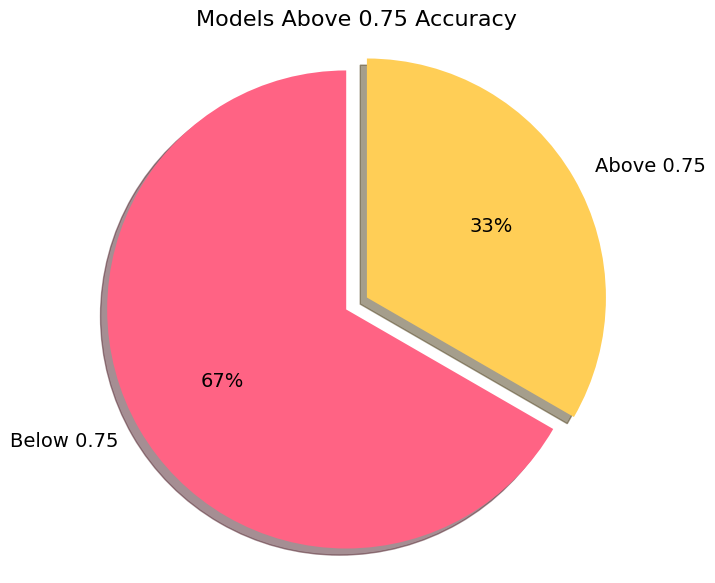

In [10]:
# ------------------- PIE CHART -------------------
labels = ['Below 0.75', 'Above 0.75']
sizes = [2, 1]
colors = ['#FF6384', '#FFCE56']
explode = (0, 0.1)

plt.figure(figsize=(7,7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.0f%%', shadow=True, startangle=90, textprops={'fontsize': 14})
plt.title('Models Above 0.75 Accuracy', fontsize=16)
plt.axis('equal')
plt.show()

In [11]:
# ------------------- COMPARISON TABLE -------------------
comparison = {
    'Model': ['RNN', 'LSTM', 'BERT'],
    'Final Validation Accuracy': [0.6815, 0.7400, 0.7875]
}
df = pd.DataFrame(comparison)
print(df)

  Model  Final Validation Accuracy
0   RNN                     0.6815
1  LSTM                     0.7400
2  BERT                     0.7875
